In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from mpl_toolkits.axes_grid1 import ImageGrid
import itertools 
import re
import os
from sklearn.model_selection import train_test_split 

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from PIL import Image
from PIL import ImageFilter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/Colab\ Datasets/DL\ Final/dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

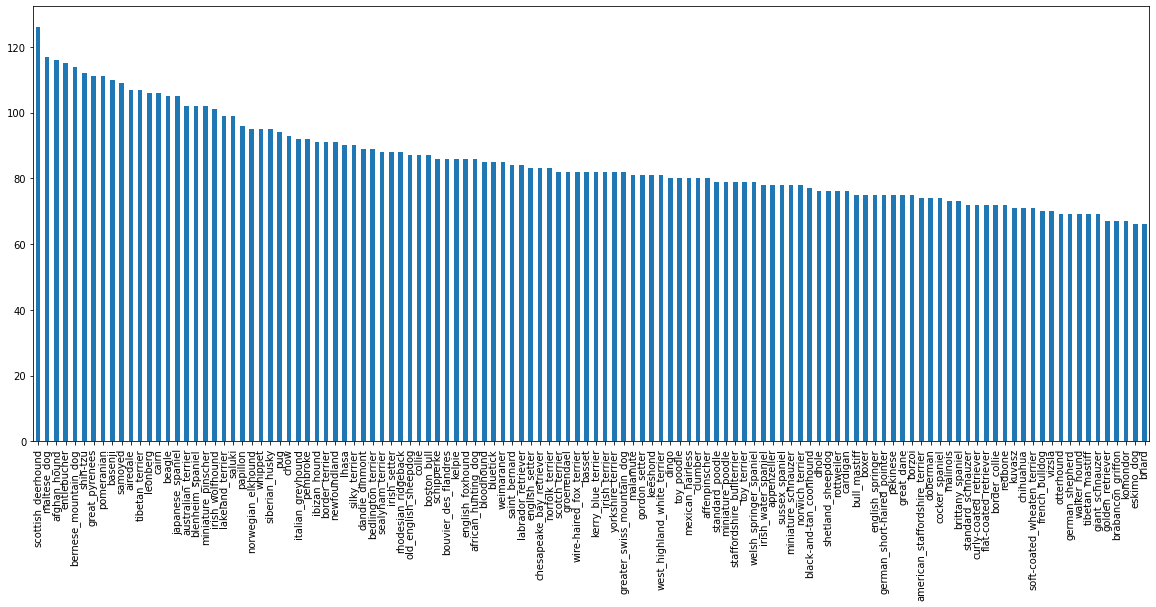

In [4]:
label = pd.read_csv('labels.csv', dtype=str)

plt.figure(figsize=(20, 8))
label['breed'].value_counts().plot(kind='bar')
plt.show()

In [5]:
def append_extention(fn):
    return fn+".jpg"
label["id"] = label["id"].apply(append_extention)

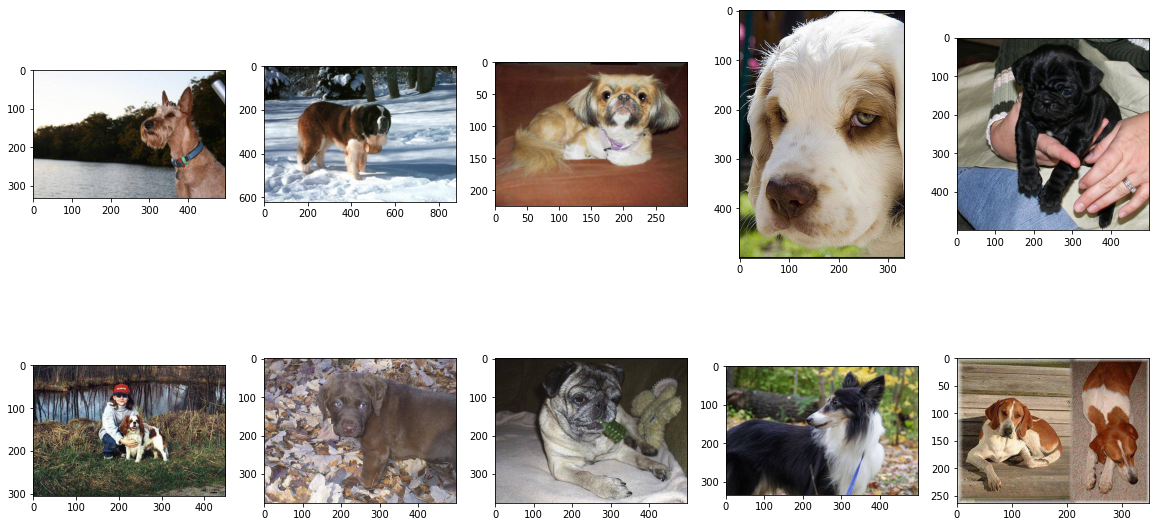

In [6]:
src_path = 'train'
sub_class = os.listdir(src_path)

plt.figure(figsize=(20,10))
for i in range(len(sub_class[:10])):
    plt.subplot(2, 5, i+1)
    img = plt.imread(os.path.join(src_path,sub_class[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [7]:
train_datagen=ImageDataGenerator( rescale=1./255.,
                                  #rotation_range = 20,
                                  #brightness_range=[0.2,1.0],
                                  #width_shift_range = 0.2,
                                  #height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #zoom_range = [0.7,1],
                                  horizontal_flip = True,
                                  #Setting validation split to 2% 
                                  validation_split=0.1 
                                  )

In [8]:
batch_size = 64
image_size=(224,224)
train_generator = train_datagen.flow_from_dataframe(
                                    dataframe=label,
                                    directory='train',
                                    x_col='id',
                                    y_col='breed',
                                    subset='training',
                                    batch_size=batch_size,
                                    seed=42,
                                    shuffle=True,
                                    class_mode='categorical',
                                    target_size=image_size,
                                    color_mode='rgb' 
)

Found 9200 validated image filenames belonging to 120 classes.


In [9]:
valid_generator = train_datagen.flow_from_dataframe(
                                            dataframe=label,
                                            directory='train',
                                            x_col='id',
                                            y_col='breed',
                                            subset='validation',
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='categorical',
                                            target_size=image_size,
                                            color_mode='rgb')

Found 1022 validated image filenames belonging to 120 classes.


In [10]:
#Create an array of train images 
filenames = ["./train/" + fname + '.jpg' for fname in label['id']]
filenames[:10]

['./train/000bec180eb18c7604dcecc8fe0dba07.jpg.jpg',
 './train/001513dfcb2ffafc82cccf4d8bbaba97.jpg.jpg',
 './train/001cdf01b096e06d78e9e5112d419397.jpg.jpg',
 './train/00214f311d5d2247d5dfe4fe24b2303d.jpg.jpg',
 './train/0021f9ceb3235effd7fcde7f7538ed62.jpg.jpg',
 './train/002211c81b498ef88e1b40b9abf84e1d.jpg.jpg',
 './train/00290d3e1fdd27226ba27a8ce248ce85.jpg.jpg',
 './train/002a283a315af96eaea0e28e7163b21b.jpg.jpg',
 './train/003df8b8a8b05244b1d920bb6cf451f9.jpg.jpg',
 './train/0042188c895a2f14ef64a918ed9c7b64.jpg.jpg']

In [11]:
# Create class names array 
class_names = label['breed'].unique()
class_names[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog'], dtype=object)

In [15]:
import tensorflow as tf 
from tensorflow.keras import layers 

def create_model():
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, 
                                                     classes = len(class_names)) 
    base_model.trainable = False 

    inputs = layers.Input(shape = (224,224,3))
    x = base_model(inputs, training = False) 
    x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling")(x)
    x = layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)


    ModelDogBreed = tf.keras.Model(inputs, outputs) 

    ModelDogBreed.compile(loss = "categorical_crossentropy", 
                         optimizer = tf.keras.optimizers.Adam(lr=0.0001), 
                         metrics=["accuracy"]) 

    return ModelDogBreed

In [16]:
model = create_model()

# Callbacks 

EarlyStoppingCallbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, baseline=None, restore_best_weights=True
)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = valid_generator.n//valid_generator.batch_size

ModelDogBreed_History = model.fit(train_generator, 
                                  steps_per_epoch = step_size_train,
                                  epochs = 100, 
                                  validation_data= valid_generator, 
                                  validation_steps = step_size_val,
                                  callbacks = [EarlyStoppingCallbacks])

Epoch 1/100
143/143 [==============================] - 48s 334ms/step - loss: 4.3691 - accuracy: 0.0714 - val_loss: 3.6878 - val_accuracy: 0.2010
Epoch 2/100
143/143 [==============================] - 47s 327ms/step - loss: 3.2897 - accuracy: 0.2782 - val_loss: 2.8660 - val_accuracy: 0.4250
Epoch 3/100
143/143 [==============================] - 47s 324ms/step - loss: 2.5630 - accuracy: 0.4491 - val_loss: 2.3142 - val_accuracy: 0.5323
Epoch 4/100
143/143 [==============================] - 46s 321ms/step - loss: 2.0696 - accuracy: 0.5564 - val_loss: 1.9239 - val_accuracy: 0.6115
Epoch 5/100
143/143 [==============================] - 46s 323ms/step - loss: 1.7425 - accuracy: 0.6169 - val_loss: 1.6877 - val_accuracy: 0.6365
Epoch 6/100
143/143 [==============================] - 46s 322ms/step - loss: 1.5050 - accuracy: 0.6627 - val_loss: 1.5197 - val_accuracy: 0.6708
Epoch 7/100
143/143 [==============================] - 46s 322ms/step - loss: 1.3381 - accuracy: 0.6934 - val_loss: 1.3847 -

In [2]:
model.evaluate(valid_data)

13/13 [==============================] - 12s 874ms/step - loss: 1.3555 - accuracy: 0.7950
[1.355473279953003, 0.7949999713897705]


In [19]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

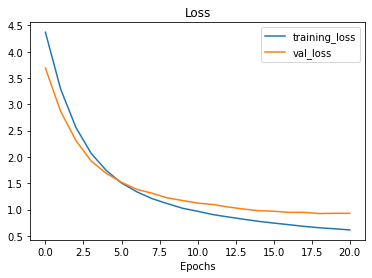

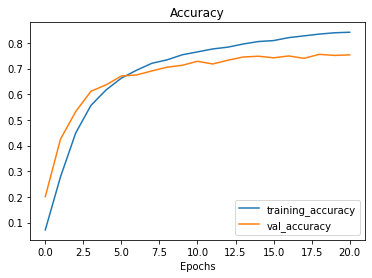

In [20]:
plot_loss_curves(ModelDogBreed_History)

In [23]:
predictions = model.predict(valid_generator)
predictions

array([[1.0773353e-03, 2.5020135e-03, 2.1078692e-06, ..., 3.4009179e-04,
        6.8007497e-04, 4.0016696e-04],
       [7.3644210e-04, 1.4062172e-02, 9.0673333e-05, ..., 9.0922018e-05,
        2.2360086e-04, 6.0668320e-04],
       [5.5381900e-04, 3.7205707e-02, 6.3474952e-05, ..., 1.7722241e-04,
        6.5077082e-05, 3.7515013e-06],
       ...,
       [2.4893170e-03, 1.3624535e-04, 1.8960574e-05, ..., 3.5406534e-05,
        4.6886223e-07, 1.8054767e-05],
       [4.6388432e-04, 1.7473623e-02, 1.5834905e-04, ..., 2.7550277e-04,
        5.7884208e-05, 4.1564021e-04],
       [1.0048148e-04, 9.2183640e-03, 2.0464602e-05, ..., 2.4570842e-04,
        6.1140000e-04, 8.8627508e-04]], dtype=float32)

In [24]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_names[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'chow'

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data:
    images.append(image)
    labels.append(class_names[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_generator)
val_images[0], val_labels[0]

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [ ]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = class_names[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()